https://towardsdatascience.com/mnist-handwritten-digits-classification-from-scratch-using-python-numpy-b08e401c4dab

In [2]:
!pip install pandas matplotlib numpy requests tqdm

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import requests, gzip, os, hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

path = f"{os.path.dirname(os.path.abspath('__file__'))}/data/"

def fetch(url):
    fp = os.path.join(path, hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            data = f.read()
    else:
        with open(fp, "wb") as f:
            data = requests.get(url).content
            f.write(data)
    return np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()

X = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28*28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [4]:
#Validation split
rand=np.arange(60000)
np.random.shuffle(rand)
train_no=rand[:50000]

val_no=np.setdiff1d(rand,train_no)

X_train,X_val=X[train_no,:,:],X[val_no,:,:]
Y_train,Y_val=Y[train_no],Y[val_no]

In [5]:
#Sigmoid funstion
def sigmoid(x):
    return 1/(np.exp(-x)+1)    

#derivative of sigmoid
def d_sigmoid(x):
    return (np.exp(-x))/((np.exp(-x)+1)**2)

In [6]:
#Softmax
def softmax(x):
    exp_element=np.exp(x-x.max())
    return exp_element/np.sum(exp_element,axis=0)

#derivative of softmax
def d_softmax(x):
    exp_element=np.exp(x-x.max())
    return exp_element/np.sum(exp_element,axis=0)*(1-exp_element/np.sum(exp_element,axis=0))

In [7]:
def init(x,y):
    layer=np.random.uniform(-1.,1.,size=(x,y))/np.sqrt(x*y)
    return layer.astype(np.float32)

np.random.seed(42)
l1=init(28*28,128)
l2=init(128,10)

In [8]:
Y_train

array([5, 5, 9, ..., 4, 3, 1], dtype=uint8)

In [9]:
ex=np.array(Y_train[1]).reshape(1,1)
ex

array([[5]], dtype=uint8)

In [10]:
example_out = np.zeros((len(ex),10), np.float32)
example_out[range(example_out.shape[0]),ex] = 1
example_out

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [11]:
#forward and backward pass
def forward_backward_pass(x,y):
    targets = np.zeros((len(y),10), np.float32)
    targets[range(targets.shape[0]),y] = 1
 
    
    x_l1=x.dot(l1)
    x_sigmoid=sigmoid(x_l1)
    x_l2=x_sigmoid.dot(l2)
    out=softmax(x_l2)
   
 
    error=2*(out-targets)/out.shape[0]*d_softmax(x_l2)
    update_l2=x_sigmoid.T@error
    
    
    error=((l2).dot(error.T)).T*d_sigmoid(x_l1)
    update_l1=x.T@error

    return out,update_l1,update_l2 


In [12]:
epochs=10000
lr=0.001
batch=128

losses,accuracies,val_accuracies=[],[],[]

from tqdm import tqdm

with tqdm(total=epochs) as pbar:
    for i in range(epochs):
        pbar.update(1)

        sample=np.random.randint(0,X_train.shape[0],size=(batch))
        x=X_train[sample].reshape((-1,28*28))
        y=Y_train[sample]


        out,update_l1,update_l2=forward_backward_pass(x,y)

        category=np.argmax(out,axis=1)
        accuracy=(category==y).mean()
        accuracies.append(accuracy)

        loss=((category-y)**2).mean()
        losses.append(loss.item())

        l1=l1-lr*update_l1
        l2=l2-lr*update_l2

        if(i%20==0):    
            X_val=X_val.reshape((-1,28*28))
            val_out=np.argmax(softmax(sigmoid(X_val.dot(l1)).dot(l2)),axis=1)
            val_acc=(val_out==Y_val).mean()
            val_accuracies.append(val_acc.item())
            
        if(i%500==0): 
            print(f'For {i}th epoch: train accuracy: {accuracy:.3f} | validation accuracy:{val_acc:.3f}')

pbar.close()


  0%|          | 15/10000 [00:00<01:36, 103.08it/s]

For 0th epoch: train accuracy: 0.086 | validation accuracy:0.071


  5%|▌         | 542/10000 [00:01<00:29, 320.51it/s]

For 500th epoch: train accuracy: 0.672 | validation accuracy:0.655


 11%|█         | 1062/10000 [00:03<00:27, 319.50it/s]

For 1000th epoch: train accuracy: 0.766 | validation accuracy:0.744


 15%|█▌        | 1542/10000 [00:05<00:30, 276.99it/s]

For 1500th epoch: train accuracy: 0.797 | validation accuracy:0.772


 21%|██        | 2065/10000 [00:07<00:26, 295.14it/s]

For 2000th epoch: train accuracy: 0.805 | validation accuracy:0.786


 26%|██▌       | 2554/10000 [00:08<00:23, 311.15it/s]

For 2500th epoch: train accuracy: 0.789 | validation accuracy:0.795


 30%|███       | 3045/10000 [00:10<00:22, 311.46it/s]

For 3000th epoch: train accuracy: 0.852 | validation accuracy:0.802


 35%|███▌      | 3539/10000 [00:11<00:20, 311.93it/s]

For 3500th epoch: train accuracy: 0.789 | validation accuracy:0.805


 40%|████      | 4042/10000 [00:13<00:18, 327.23it/s]

For 4000th epoch: train accuracy: 0.820 | validation accuracy:0.809


 45%|████▌     | 4536/10000 [00:15<00:17, 320.15it/s]

For 4500th epoch: train accuracy: 0.812 | validation accuracy:0.812


 50%|█████     | 5042/10000 [00:16<00:14, 333.55it/s]

For 5000th epoch: train accuracy: 0.852 | validation accuracy:0.816


 56%|█████▌    | 5562/10000 [00:18<00:13, 326.68it/s]

For 5500th epoch: train accuracy: 0.844 | validation accuracy:0.818


 60%|██████    | 6042/10000 [00:20<00:12, 319.43it/s]

For 6000th epoch: train accuracy: 0.812 | validation accuracy:0.821


 65%|██████▌   | 6542/10000 [00:21<00:10, 319.27it/s]

For 6500th epoch: train accuracy: 0.859 | validation accuracy:0.823


 70%|███████   | 7043/10000 [00:23<00:09, 310.64it/s]

For 7000th epoch: train accuracy: 0.812 | validation accuracy:0.823


 76%|███████▌  | 7559/10000 [00:25<00:07, 332.73it/s]

For 7500th epoch: train accuracy: 0.766 | validation accuracy:0.823


 80%|████████  | 8042/10000 [00:26<00:06, 297.15it/s]

For 8000th epoch: train accuracy: 0.828 | validation accuracy:0.824


 86%|████████▌ | 8562/10000 [00:28<00:04, 310.97it/s]

For 8500th epoch: train accuracy: 0.852 | validation accuracy:0.824


 91%|█████████ | 9061/10000 [00:30<00:03, 303.00it/s]

For 9000th epoch: train accuracy: 0.805 | validation accuracy:0.825


 96%|█████████▌| 9562/10000 [00:31<00:01, 319.52it/s]

For 9500th epoch: train accuracy: 0.781 | validation accuracy:0.826


100%|██████████| 10000/10000 [00:33<00:00, 299.80it/s]


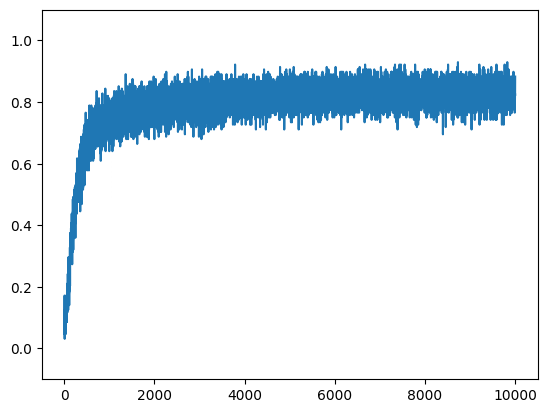

In [13]:
# plt.ylim(-0.1, 1.1)


def plot(y):
  x = [i for i in range(1, len(y) + 1)]
  fig, ax = plt.subplots()
  plt.ylim(-0.1, 1.1)
  ax.plot(x, y) #, linewidth=2.0)
  plt.show()



plot(accuracies)

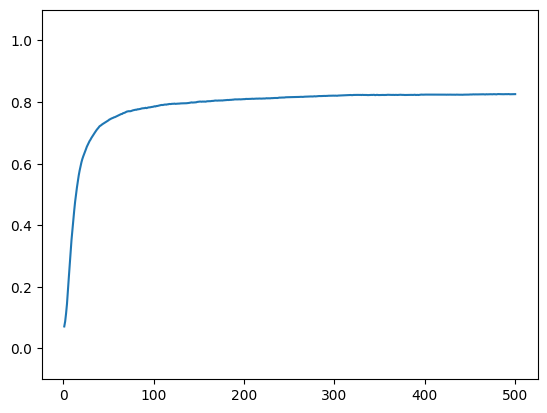

In [14]:
plot(val_accuracies)

In [15]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable


In [16]:
from tqdm import tqdm
from time import sleep

with tqdm(total=100) as pbar:
    for i in range(9):
        sleep(0.1)
        pbar.update(10)
pbar.close()

 90%|█████████ | 90/100 [00:00<00:00, 99.16it/s]


In [17]:
# def test_prediction():
#   index = int(input("Enter a number (0 - 59999): "))
#   img = images[index]
#   print(img.shape)
#   plt.imshow(img.reshape(28, 28), cmap="Greys")

#   img.shape += (1,)
#   # Forward propagation input -> hidden
#   h_pre = b_i_h + w_i_h @ img.reshape(784, 1)

#   h = 1 / (1 + np.exp(-h_pre))

#   # Forward propagation hidden -> output
#   o_pre = b_h_o + w_h_o @ h
#   o = 1 / (1 + np.exp(-o_pre))


#   plt.title(f"Index: {index} \nLabel: {labels[index].argmax()} \nPrediction: {o.argmax()}")
#   plt.show()